Let's see if we can automatically align two photos by looking at the differences in pixel intensity.

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as pyplot

%matplotlib inline

In [2]:
dir_path = '/Users/elgehelge/Downloads/OUTPUT/captured_raw/'
img_base_name = '2018-07-24T12:58:25.948957'
img_names = [img_base_name + '_' + str(i) for i in range(1, 5)]

In [3]:
imgs = [imageio.imread(dir_path + name) for name in img_names]
gray_imgs = [img.mean(axis=-1).astype(int) for img in imgs]

This is what two of the photos looks like as gray scale:

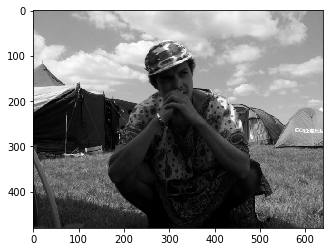

In [4]:
pyplot.imshow(gray_imgs[0], cmap=pyplot.cm.gray)

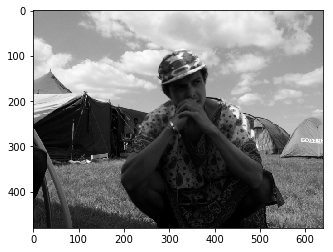

In [5]:
pyplot.imshow(gray_imgs[1], cmap=pyplot.cm.gray)

This is the gray scale intensity difference per pixel:

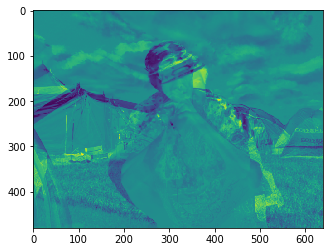

In [6]:
pyplot.imshow(gray_imgs[0] - gray_imgs[1])

Let's summarize that by the mean of the absolute pixel differences:

In [7]:
def mean_pixel_diff(img1, img2):
    return np.abs(img1 - img2).mean()

In [8]:
mean_pixel_diff(gray_imgs[0], gray_imgs[1])

28.015143229166668

And now, let's try shifting the images to a better position and calculate the mean pixel difference again:

In [9]:
def crop(img, left, top, right, bottom):
    height = img.shape[0]
    width = img.shape[1]
    return img[top:height-bottom, left:width-right]

def shift(img1, img2, x, y):
    left, right = (abs(x), 0) if x < 0 else (0, x)
    top, bottom = (abs(y), 0) if y < 0 else (0, y)
    img1_shifted = crop(img1, left, top, right, bottom)
    img2_shifted = crop(img2, right, bottom, left,  top)
    return img1_shifted, img2_shifted

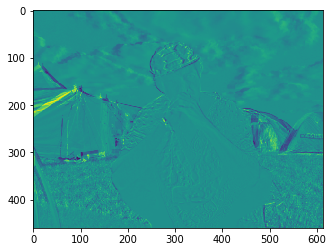

In [10]:
new_img1, new_img2 = shift(gray_imgs[0], gray_imgs[1], x=27, y=20)
pyplot.imshow(new_img1 - new_img2)

In [11]:
mean_pixel_diff(new_img1, new_img2)

13.516859351727073

That is certainly a smaller number!

Let's minimize the mean pixel difference algorithmically

In [12]:
def align_images(shift_img, base_img):
    """Align images by searching for minimum pixel difference
    
    Returns the optimal x and y distance to shift images
    """
    x, y = 0, 0
    search_options = [
        (-20, 0), (0, -20), (20, 0), (0, 20),
        (-5, 0), (0, -5), (5, 0), (0, 5),
        (-1, 0), (0, -1), (1, 0), (0, 1),
    ]
    current_diff = mean_pixel_diff(*shift(shift_img, base_img, x, y))
    found_minimum = False
    while not found_minimum:
        for count, (dx, dy) in enumerate(search_options):
            shifted_imgs = shift(shift_img, base_img, x + dx, y + dy)
            new_diff = mean_pixel_diff(*shifted_imgs)
            if new_diff < current_diff:
                x += dx
                y += dy
                current_diff = new_diff
                break  # break the for-loop and start over
            if count == len(search_options) - 1:
                found_minimum = True
    return x, y

In [13]:
best_coordinates = align_images(gray_imgs[0], gray_imgs[1])
best_coordinates

(26, 20)

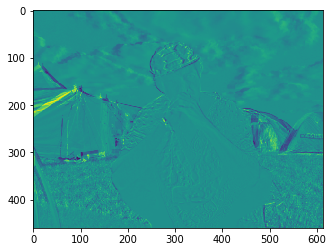

In [14]:
best_img1, best_img2 = shift(gray_imgs[0], gray_imgs[1], *best_coordinates)
pyplot.imshow(new_img1 - new_img2)

Not bad ;)

Let's align all the images..

In [15]:
relative_shift = [(0, 0)] + \
                 [align_images(gray_imgs[i], gray_imgs[i + 1]) for i in range(len(gray_imgs) - 1)]
relative_shift

[(0, 0), (26, 20), (-16, 10), (37, -22)]

In [16]:
shifts = np.array(relative_shift).cumsum(axis=0) * -1
shifts

array([[  0,   0],
       [-26, -20],
       [-10, -30],
       [-47,  -8]])

In [17]:
right_bottom = shifts - shifts.min(axis=0)
left_top = (shifts - shifts.max(axis=0)) * -1
crop_l_t_r_b = np.concatenate([left_top, right_bottom], axis=1)
crop_l_t_r_b

array([[ 0,  0, 47, 30],
       [26, 20, 21, 10],
       [10, 30, 37,  0],
       [47,  8,  0, 22]])

Final result:

In [18]:
imgs_cropped = [crop(img, *crop_size) for img, crop_size in zip(imgs, crop_l_t_r_b)]

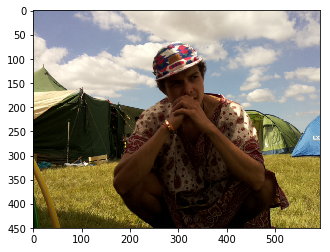

In [19]:
pyplot.imshow(imgs_cropped[0])

In [20]:
import glob
import os

all_images = glob.glob(dir_path + '*')
all_images_base = list({os.path.basename(file_path)[:-2] for file_path in all_images})

for image_base in all_images_base:
    img_names = [image_base + '_' + str(i) for i in range(1, 5)]
    imgs = [imageio.imread(dir_path + name) for name in img_names]
    imgs_gray = [img.mean(axis=-1).astype(int) for img in imgs]
    relative_shift = [(0, 0)] + \
                     [align_images(imgs_gray[i], imgs_gray[i + 1]) for i in range(len(imgs_gray) - 1)]
    shifts = np.array(relative_shift).cumsum(axis=0) * -1
    right_bottom = shifts - shifts.min(axis=0)
    left_top = (shifts - shifts.max(axis=0)) * -1
    crop_l_t_r_b = np.concatenate([left_top, right_bottom], axis=1)
    imgs_cropped = [crop(img, *crop_size) for img, crop_size in zip(imgs, crop_l_t_r_b)]

    imageio.mimwrite('/Users/elgehelge/Downloads/OUTPUT/auto_aligned/' + image_base + '.gif',
                     imgs_cropped,
                     fps=8)